# Part 2: Gender related or not - Zero-Shot Extraction and Article Classifier

**Contesting Gender Equality? A Computational Analysis of Backlash in Gender-Related News Media**

A Semester Project by Julia Jensine Häfker

MSc. Business Data Science

Aalborg University

Hand In: 17.12.2026

# Setup

## Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
import matplotlib.pyplot as plt

#--- IMPORTS FOR CLASSIFICATION ---

# Scikit-learn for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Sentence Transformers for embeddings
from sentence_transformers import SentenceTransformer

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


/opt/anaconda3/envs/bertopic-clean/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Full Data

Reloading the dataset from the previous notebook.

In [3]:
df = pd.read_parquet("df_full_clean.parquet")

In [4]:
df.head()

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars
0,1060458,1980,Dem Andenken Rudi Dutschkes,Christian Semler zum Tode eines Freundes und G...,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",2748,"[archiv, archiv, nachrichten, news, taz, tages...",17914
1,1060457,1983,Der Papst in Polen: Injektion der Hoffnung,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",2692,"[archiv, archiv, nachrichten, news, taz, tages...",17077
2,1060456,1984,Polnischer Monolog oder westlich-intellektuell...,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",1881,"[archiv, archiv, nachrichten, news, taz, tages...",11266
3,1060455,1985,Der Macht gegenüber politisch verhalten,Die Bedeutung des „Prager Aufrufs“ für die Fri...,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",3717,"[archiv, archiv, nachrichten, news, taz, tages...",23397
4,1060454,1985,„Anlaß zur Unruhe“*,Anmerkungen zu Agnes Hellers und Ferenc Fehers...,Von Dieter Esche und Christian Semler *** Erst...,Dieter Esche / Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",12503,"[archiv, archiv, nachrichten, news, taz, tages...",80607


# 3. Classification

## 3.1. Zero-Shot Classification with an LLM

### 3.1.1. Prompt for Sample Classification

**Modell:** gpt-oss:20b

**Prompt:**

You are a precise binary classifier. 
For each input article, decide whether the article is gender-related or not gender-related.

Apply the rubric below exactly and produce output in the required JSON schema. Be concise, consistent, and deterministic.

Classify the following article. 
Use the label "gender-related" only when the article’s primary topic or a clear, central part of the piece concerns 
- gender, 
- gender identity, 
- gender roles, 
- gender-based discrimination or violence, 
- gender policy or legal issues, 
- gender statistics, 
- campaigns or movements focused on gender, 
- explicit gendered stereotypes or gender-targeted marketing, 
- trans or non-binary topics, 
- or discussions of pronouns and gender identity. 

If gender is only mentioned incidentally 
(for example: “female doctor” used as a descriptive detail with no discussion about gender implications), 
label it "not gender-related".

CONFIDENCE SPECIFICATION (MUST follow exactly)
- The field "confidence" must be a numeric value between 0.00 and 1.00 inclusive, formatted with two decimal places (for example 0.00, 0.37, 0.95). Do not use percent signs or words.
- Use these operational ranges and assign the numeric value consistent with the textual cues below:

  0.90–1.00 (Very high/near-certain): explicit, central gender focus — gender is the article's main topic (headline and multiple paragraphs focus on gender; presence of explicit gender policy/statistics/quotations about gender or clear campaign). Choose a number ≥ 0.90 (e.g., 0.95) when evidence is compelling and unambiguous.

  0.75–0.89 (High): strong evidence gender is a primary or substantial topic but with minor ambiguity or less extensive supporting text (e.g., several paragraphs about gender but not headline; or headline + one paragraph).

  0.60–0.74 (Moderate): gender is clearly present and relevant but not central — e.g., article discusses gender alongside many other topics, or contains substantial gender-related quotes/claims but lacks concentrated treatment.

  0.50–0.59 (Borderline): ambiguous cases where gender may be an important subtopic but evidence is weak or confined to a brief paragraph; choose values in this band when the label is uncertain.

  0.00–0.49 (Low / Not confident / Not gender-related):
    - 0.00–0.10: explicit, clear non-gender topic with incidental gender mention (e.g., single descriptive phrase without implication).
    - 0.11–0.49: some weak or suggestive gender language but insufficient to treat the article as gender-related.

When you label gender-related, give a 1–2 sentence justification and include a short excerpt (max 30 words) 
from the article that best supports the label. 

When you label not gender-related, give a 1–2 sentence justification explaining why the gender mention is incidental or absent.

Output format (strict JSON, one object only — DO NOT add extra text):
{
"id": "<article id from input>",
"label": "gender-related" | "not gender-related",
"confidence": 0.00,
"reason": "<one or two concise sentences>",
"evidence_excerpt": "<short excerpt up to 30 words; empty string if none>"
}

**Final Labels:** "gender-related", "not gender-related", Confidence level: 0.00-1.00

**Code can be found here:** Appendix X

### 3.1.2. Load Training Data 

In the following code I will load the training data created by the LLM.

In [5]:
# Here I need to implement the labeled dataset back into the df

with open("gender_classification_labeled_full2k.json", "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []
for item in data.get("results", []):
    content = item.get("content", {})
    if isinstance(content, str):
        try:
            content = json.loads(content)
        except Exception:
            content = {}
    # merge top-level fields (except raw content) with parsed content
    merged = {k: v for k, v in item.items() if k != "content"}
    merged.update(content)
    rows.append(merged)

df_llm = pd.DataFrame(rows)
df_llm["confidence"] = pd.to_numeric(df_llm.get("confidence"), errors="coerce")

print(df_llm.columns.tolist())
df_llm.head()

['article_id', 'title', 'text', 'thinking', 'id', 'label', 'confidence', 'reason', 'evidence_excerpt']


,article_id,title,text,thinking,id,label,confidence,reason,evidence_excerpt
0,1874332,Weniger französische UNIFIL–Truppen,New York (ap) - Frankreich vermindert sein Kon...,We need to decide if the article is gender-rel...,,not gender-related,0.00,The article is about France reducing its UNIFI...,
1,1873117,USA kürzen Hilfen für Südafrika,Washington (ips) - Mit der „geringen strategis...,"We have a German article: ""USA kürzen Hilfen f...",,not gender-related,0.00,The article discusses US aid cuts to Africa wi...,
2,1877716,Kronzeuge gegen Daniloff,Moskau (dpa/ap) - Der ehemalige Agent des amer...,We need to classify the article as gender-rela...,title: Kronzeuge gegen Daniloff,not gender-related,0.00,The article discusses espionage and political ...,
3,1878273,D O K U M E N T A T I O N Lebensmanifest,Die ehemalige österreichische Präsidentschafts...,We need to determine if the article is gender-...,title: D O K U M E N T A T I O N Lebensmanifest,not gender-related,0.05,The piece centers on anti-nuclear activism and...,
4,1875071,I N T E R V I E W Aufbruch nach hinten,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",We need to determine if article is gender-rela...,I N T E R V I E W Aufbruch nach hinten,not gender-related,0.05,The article discusses SPD campaign strategy an...,„Wahlkämpferinnen und Wahlkämpfer der SPD in e...


I will drop the "id" and "evidence_excerpt" column cause we don't need it.

In [6]:
df_llm = df_llm.drop(columns=["id", "evidence_excerpt"])
df_llm.head()

,article_id,title,text,thinking,label,confidence,reason
0,1874332,Weniger französische UNIFIL–Truppen,New York (ap) - Frankreich vermindert sein Kon...,We need to decide if the article is gender-rel...,not gender-related,0.00,The article is about France reducing its UNIFI...
1,1873117,USA kürzen Hilfen für Südafrika,Washington (ips) - Mit der „geringen strategis...,"We have a German article: ""USA kürzen Hilfen f...",not gender-related,0.00,The article discusses US aid cuts to Africa wi...
2,1877716,Kronzeuge gegen Daniloff,Moskau (dpa/ap) - Der ehemalige Agent des amer...,We need to classify the article as gender-rela...,not gender-related,0.00,The article discusses espionage and political ...
3,1878273,D O K U M E N T A T I O N Lebensmanifest,Die ehemalige österreichische Präsidentschafts...,We need to determine if the article is gender-...,not gender-related,0.05,The piece centers on anti-nuclear activism and...
4,1875071,I N T E R V I E W Aufbruch nach hinten,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",We need to determine if article is gender-rela...,not gender-related,0.05,The article discusses SPD campaign strategy an...


### 3.1.3. Quick check of the data

In [7]:
counts = df_llm["label"].value_counts()
print(counts)

label
not gender-related    1910
gender-related          89
Name: count, dtype: int64


As expected the data is extremely unbalanced. We will build a balanced dataframe based on this.

<Figure size 600x400 with 0 Axes>

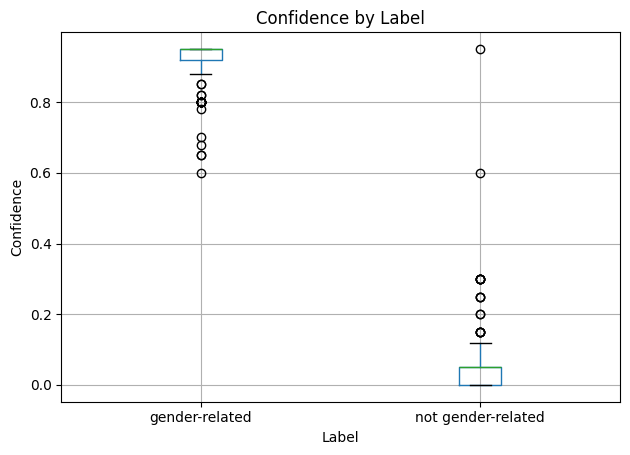

In [8]:
plt.figure(figsize=(6,4))

df_llm.boxplot(column="confidence", by="label")
plt.title("Confidence by Label")
plt.suptitle("")
plt.xlabel("Label")
plt.ylabel("Confidence")
plt.tight_layout()
plt.show()

To be sure we check for missing data.

In [9]:
df_llm.isna().sum()

article_id    0
title         0
text          0
thinking      0
label         1
confidence    1
reason        1
dtype: int64

There is missing data so we need to inspect where and why.

In [10]:
df_missing = df_llm[df_llm.isna().any(axis=1)]
df_missing

,article_id,title,text,thinking,label,confidence,reason
980,‚,"die bremer kinotaz - alle Filme, alle Termine","Bärenbrüder USA 2003, R: Aaron Blaise, Robert ...","The user asks: ""The user: 'Give me a brief des...",NaN,NaN,NaN


The LLM could not label this article because it contained to much different information and was too long. For this case, the article will just be dropped. But it is noted, that the long data maybe needs to be cleaned after all and the prompt should maybe be adapted.

In [11]:
df_llm = df_llm.dropna()

In [12]:
df_llm.isna().sum()

article_id    0
title         0
text          0
thinking      0
label         0
confidence    0
reason        0
dtype: int64

### 3.1.4. Human in the loop

The classification was checked on a surface level. More elaborate insights can be found in the final report. 

To create a gold-standard training dataset, a human coder would have to check all 2.000 articles.

In [17]:
LOWER_CONF = 0.1
UPPER_BOUND = 0.5   # decision boundary

df_not_gender_conf = df_llm[
    (df_llm["label"].str.strip().str.lower() == "not gender-related") &
    (df_llm["confidence"] > LOWER_CONF) &
    (df_llm["confidence"] < UPPER_BOUND)
].copy()

print("NOT gender-related (confidence > 0.1):", len(df_not_gender_conf))

NOT gender-related (confidence > 0.1): 18


In [18]:
df_not_gender_conf["article_id"].tolist()

['1700324',
 '1442487',
 '1480967',
 '1419434',
 '1291269',
 '1288946',
 '1248851',
 '820104',
 '772062',
 '0223569',
 '642419',
 '0332126',
 '5101991',
 '526991',
 '5268569',
 '5279804',
 '5725632',
 '5947638']

In [19]:
hard_negative_ids = df_not_gender_conf["article_id"]

df_hard_negatives = df_llm[
    df_llm["article_id"].isin(hard_negative_ids)
].copy()

print("Hard negatives:", len(df_hard_negatives))

Hard negatives: 18


## 3.2. Create balanced dataframe for analysis

The data is heavily inbalanced. In the following I will create a balanced.

### 3.2.1. Merge LLM Data into the full Dataframe

The LLM output does not contain information such as the year, which we need for our anylsis. We therefore load the LLM input sample back into the notebook and then merge both.

In [13]:
sample_df = pd.read_json("gender_classification_sample_full2k.jsonl", lines=True)
sample_df.head()

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned
0,1874332,1986,Weniger französische UNIFIL–Truppen,,New York (ap) - Frankreich vermindert sein Kon...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",62,"[archiv, archiv, nachrichten, news, taz, tages..."
1,1873117,1986,USA kürzen Hilfen für Südafrika,,Washington (ips) - Mit der „geringen strategis...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",78,"[archiv, archiv, nachrichten, news, taz, tages..."
2,1877716,1986,Kronzeuge gegen Daniloff,,Moskau (dpa/ap) - Der ehemalige Agent des amer...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",141,"[archiv, archiv, nachrichten, news, taz, tages..."
3,1878273,1986,D O K U M E N T A T I O N Lebensmanifest,■ „In unsere Welt kommt immer mehr Sterben...“,Die ehemalige österreichische Präsidentschafts...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",351,"[archiv, archiv, nachrichten, news, taz, tages..."
4,1875071,1986,I N T E R V I E W Aufbruch nach hinten,■ Motivationsprobleme der SPD nach Hamburg,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",Jakob Sonnenschein,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",283,"[archiv, archiv, nachrichten, news, taz, tages..."


Now we create a dataframe, which contains all the information. This step basically merges the input and output of the LLM back together.

In [14]:
# make sure article_id is str type in both dataframes
df_llm['article_id'] = df_llm['article_id'].astype(str)
sample_df['article_id'] = sample_df['article_id'].astype(str)

The LLM outputs the ‘article_id’ is padded with a 0. For example, 396505 becomes 0396505. However, the article ID is our most important anchor for merging the two df files. We therefore need to standardise them.

In [15]:
df_llm["article_id_norm"] = df_llm["article_id"].astype(str).str.lstrip("0")
sample_df["article_id_norm"] = sample_df["article_id"].astype(str).str.lstrip("0")

With this standardised data, we can now proceed and merge both dataframes back together.

In [16]:
# new dataframe name df_llm_clean

# sanity checks
assert "article_id_norm" in df_llm.columns
assert "article_id_norm" in sample_df.columns

# merge based on matching article_id_norm
df_llm_clean = df_llm.merge(
    sample_df,
    on="article_id_norm",
    suffixes=("", "_sample")
)

df_llm_clean.head()
print(len(df_llm_clean))

1999


In [17]:
df_llm_clean.head()

,article_id,title,text,thinking,label,confidence,reason,article_id_norm,article_id_sample,year,title_sample,teaser,text_sample,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned
0,1874332,Weniger französische UNIFIL–Truppen,New York (ap) - Frankreich vermindert sein Kon...,We need to decide if the article is gender-rel...,not gender-related,0.00,The article is about France reducing its UNIFI...,1874332,1874332,1986,Weniger französische UNIFIL–Truppen,,New York (ap) - Frankreich vermindert sein Kon...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",62,"[archiv, archiv, nachrichten, news, taz, tages..."
1,1873117,USA kürzen Hilfen für Südafrika,Washington (ips) - Mit der „geringen strategis...,"We have a German article: ""USA kürzen Hilfen f...",not gender-related,0.00,The article discusses US aid cuts to Africa wi...,1873117,1873117,1986,USA kürzen Hilfen für Südafrika,,Washington (ips) - Mit der „geringen strategis...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",78,"[archiv, archiv, nachrichten, news, taz, tages..."
2,1877716,Kronzeuge gegen Daniloff,Moskau (dpa/ap) - Der ehemalige Agent des amer...,We need to classify the article as gender-rela...,not gender-related,0.00,The article discusses espionage and political ...,1877716,1877716,1986,Kronzeuge gegen Daniloff,,Moskau (dpa/ap) - Der ehemalige Agent des amer...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",141,"[archiv, archiv, nachrichten, news, taz, tages..."
3,1878273,D O K U M E N T A T I O N Lebensmanifest,Die ehemalige österreichische Präsidentschafts...,We need to determine if the article is gender-...,not gender-related,0.05,The piece centers on anti-nuclear activism and...,1878273,1878273,1986,D O K U M E N T A T I O N Lebensmanifest,■ „In unsere Welt kommt immer mehr Sterben...“,Die ehemalige österreichische Präsidentschafts...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",351,"[archiv, archiv, nachrichten, news, taz, tages..."
4,1875071,I N T E R V I E W Aufbruch nach hinten,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",We need to determine if article is gender-rela...,not gender-related,0.05,The article discusses SPD campaign strategy an...,1875071,1875071,1986,I N T E R V I E W Aufbruch nach hinten,■ Motivationsprobleme der SPD nach Hamburg,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",Jakob Sonnenschein,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",283,"[archiv, archiv, nachrichten, news, taz, tages..."


### 3.2.2. Only Gender-related

In this step I extract all 89 articles which were labeled as gender-related.

In [18]:
# Extract the gender related articles and store them in a df

df_gender = df_llm_clean[
    df_llm_clean["label"] == "gender-related"
].copy()

print(len(df_gender))

89


### 3.2.3. Create stratisfied sample of non-gender related

I then get a sample of 89 not gender-related articles.

In [19]:
df_no_gender = df_llm_clean[
    df_llm_clean["label"] == "not gender-related"
].copy()

print(len(df_no_gender))

1910


In [21]:
year_table = (
    df_llm_clean
    .groupby("year")
    .size()
    .reset_index(name="n_articles")
)

In [22]:
samples = []
rng = 42

for _, row in year_table.iterrows():
    year = row["year"]
    k = row["n_articles"]

    grp = df_no_gender[df_no_gender["year"] == year]
    if len(grp) == 0:
        print(f"Warning: no rows in df_no_gender for year {year}, skipping.")
        continue
    replace = len(grp) < k
    sampled = grp.sample(n=k, replace=replace, random_state=rng)
    samples.append(sampled)

sample_df = pd.concat(samples, ignore_index=True)

print(sample_df["year"].value_counts().sort_index())

year
1986     6
1987    19
1988    27
1989    35
1990    51
1991    37
1992    53
1993    61
1994    62
1995    61
1996    63
1997    62
1998    63
1999    59
2000    65
2001    66
2002    68
2003    69
2004    79
2005    71
2006    69
2007    62
2008    59
2009    57
2010    56
2011    57
2012    59
2013    55
2014    53
2015    53
2016    52
2017    48
2018    41
2019    40
2020    37
2021    35
2022    32
2023    31
2024    26
Name: count, dtype: int64


### 3.2.4. Merge only gender related and sample of not gender related back together

Lastly, I merge both frames together to create the finale balanced dateframe.

In [23]:
#merging both dataframes to get the final balanced dataframe
df_class = pd.concat([df_gender, sample_df], ignore_index=True)

In [24]:
df_class.head()

,article_id,title,text,thinking,label,confidence,reason,article_id_norm,article_id_sample,year,title_sample,teaser,text_sample,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned
0,1796330,Beide haben die Verantwortung-betr.: dito,betr.: dito Von wegen: Väter bekommen kein Sor...,We need to decide if article is gender-related...,gender-related,0.95,The article centers on gender roles and custod...,1796330,1796330,1989,Beide haben die Verantwortung-betr.: dito,,betr.: dito Von wegen: Väter bekommen kein Sor...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",311,"[archiv, archiv, nachrichten, news, taz, tages..."
1,1783017,"""Das andere Geschlecht""","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",We need to determine if the article is gender-...,gender-related,0.80,The article’s title and content revolve around...,1783017,1783017,1990,"""Das andere Geschlecht""","■ Betr.: ""Hit des Tages"", taz vom 20.1.90","Betr.: „Hit des Tages“, taz vom 20.1.90 Wie sc...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",103,"[archiv, archiv, nachrichten, news, taz, tages..."
2,1764043,Ohne Mähne,betr.: „Angriffslustig und nicht unumstritten“...,We need to classify whether article is gender-...,gender-related,0.95,The article explicitly discusses female langua...,1764043,1764043,1990,Ohne Mähne,"■ betr: ""Angriffslustig und nicht unumstritten...",betr.: „Angriffslustig und nicht unumstritten“...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",48,"[archiv, archiv, nachrichten, news, taz, tages..."
3,1779613,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,Frauenpolitik wird im rot-grünen Senat zwar gr...,"We need to classify article: it's about ""Fraue...",gender-related,0.95,The article focuses on women’s political initi...,1779613,1779613,1990,Utopie der Frauen-Selbsthilfe - und ihre Verhi...,■ Sozialsenatsverwaltung legt ihre Vorstellung...,Frauenpolitik wird im rot-grünen Senat zwar gr...,ulrike helwerth,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",616,"[archiv, archiv, nachrichten, news, taz, tages..."
4,1722251,Lehrstellen für Frauen,Dresden. Um der Benachteiligung von jungen Mäd...,"We need to classify. The article: ""Lehrstellen...",gender-related,0.95,The piece focuses on a quota system aimed at a...,1722251,1722251,1991,Lehrstellen für Frauen,,Dresden. Um der Benachteiligung von jungen Mäd...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",62,"[archiv, archiv, nachrichten, news, taz, tages..."


## 3.3. Create Embeddings (SBERT) and build Classifier

### 3.3.1. Train-Test-Split

Firstly, I divide the labeled dataset into test and training data.

In [ ]:
X = df_class['text']
y = df_class['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 133
Testing samples: 45


### 3.3.2. Pipeline: SBERT & Classical Models

The pipeline uses a multilingual pre-trained transformer model to create embeddings. It then uses Logistic Regression and SVM on these embeddings.

In [ ]:
# Load a pre-trained SBERT model
print("Loading SBERT model...")
embedding_model = SentenceTransformer('intfloat/multilingual-e5-small')

# Generate embeddings (this can take a moment)
print("Generating embeddings for training data...")
X_train_embeddings = embedding_model.encode(X_train.tolist(), show_progress_bar=True)

print("Generating embeddings for test data...")
X_test_embeddings = embedding_model.encode(X_test.tolist(), show_progress_bar=True)

print(f"Shape of training embeddings: {X_train_embeddings.shape}")

# --- Train classifiers on embeddings ---
# Logistic Regression
print("\nTraining SBERT + Logistic Regression...")
clf_lr_sbert = LogisticRegression(random_state=42, max_iter=1000)
clf_lr_sbert.fit(X_train_embeddings, y_train)

# SVM
print("Training SBERT + SVM...")
clf_svm_sbert = SVC(random_state=42, kernel='linear', C=1.0)
clf_svm_sbert.fit(X_train_embeddings, y_train)

# Evaluate models
y_pred_lr_sbert = clf_lr_sbert.predict(X_test_embeddings)
y_pred_svm_sbert = clf_svm_sbert.predict(X_test_embeddings)

# Store results
results = {}
results['SBERT + Logistic Regression'] = accuracy_score(y_test, y_pred_lr_sbert)
results['SBERT + SVM'] = accuracy_score(y_test, y_pred_svm_sbert)

print("\n--- SBERT + Logistic Regression Results ---")
print(f"Accuracy: {results['SBERT + Logistic Regression']:.4f}")
print(classification_report(y_test, y_pred_lr_sbert))

print("\n--- SBERT + SVM Results ---")
print(f"Accuracy: {results['SBERT + SVM']:.4f}")
print(classification_report(y_test, y_pred_svm_sbert))

Loading SBERT model...
Generating embeddings for training data...


Batches: 100%|██████████| 5/5 [01:27<00:00, 17.41s/it]


Generating embeddings for test data...


Batches: 100%|██████████| 2/2 [00:26<00:00, 13.28s/it]

Shape of training embeddings: (133, 384)

Training SBERT + Logistic Regression...
Training SBERT + SVM...

--- SBERT + Logistic Regression Results ---
Accuracy: 0.7556
                    precision    recall  f1-score   support

    gender-related       0.93      0.57      0.70        23
not gender-related       0.68      0.95      0.79        22

          accuracy                           0.76        45
         macro avg       0.80      0.76      0.75        45
      weighted avg       0.81      0.76      0.75        45


--- SBERT + SVM Results ---
Accuracy: 0.7333
                    precision    recall  f1-score   support

    gender-related       0.92      0.52      0.67        23
not gender-related       0.66      0.95      0.78        22

          accuracy                           0.73        45
         macro avg       0.79      0.74      0.72        45
      weighted avg       0.79      0.73      0.72        45



Both classifiers reach around 73–76% accuracy, which is moderate.

The models do not perform symmetrically across classes: they are much better at identifying not gender-related articles than gender-related ones.

This trade-off is valid for our analysis. It is more important to not have articles falsely classified as gender-related, then the other way around.

## 3.4. Sample 100k cases

As we are working with big amounts of data, this analysis will pull a sample of 100k articles, stratisfied over time/ years.

In [ ]:
TARGET_N = 100000
rng = 42

# If df has fewer than TARGET_N rows, just sample everything
if len(df) <= TARGET_N:
    df_100k = df.sample(n=len(df), random_state=rng)
else:
    # 1) Count how many articles per year exist in df
    year_counts = df["year"].value_counts().sort_index()
    year_table = year_counts.reset_index()
    year_table.columns = ["year", "n_total"]

    # 2) Compute target sample size per year (proportional to n_total)
    total = year_table["n_total"].sum()
    year_table["n_float"] = year_table["n_total"] / total * TARGET_N

    # 3) Round to integers
    year_table["n_sample"] = year_table["n_float"].round().astype(int)

    # 4) Fix rounding so that sum(n_sample) == TARGET_N
    diff = TARGET_N - year_table["n_sample"].sum()
    if diff != 0:
        fracs = year_table["n_float"] - year_table["n_sample"]
        # sort by fractional part; ascending if we need to remove, descending if we need to add
        order = fracs.sort_values(ascending=(diff < 0)).index

        for idx in order[:abs(diff)]:
            year_table.loc[idx, "n_sample"] += 1 if diff > 0 else -1

    assert year_table["n_sample"].sum() == TARGET_N

    # 5) Sample per year
    samples = []
    for _, row in year_table.iterrows():
        year = row["year"]
        k = int(row["n_sample"])
        if k <= 0:
            continue

        grp = df[df["year"] == year]
        if len(grp) == 0:
            print(f"Warning: no rows in df for year {year}, skipping.")
            continue

        # just in case, do not request more than exist
        k_eff = min(k, len(grp))
        sampled = grp.sample(n=k_eff, replace=False, random_state=rng)
        samples.append(sampled)

    df_100k = pd.concat(samples, ignore_index=True)

print(len(df_100k))

100000


In [175]:
df_100k.head()

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars
0,1874332,1986,Weniger französische UNIFIL–Truppen,,New York (ap) - Frankreich vermindert sein Kon...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",62,"[archiv, archiv, nachrichten, news, taz, tages...",355
1,1873117,1986,USA kürzen Hilfen für Südafrika,,Washington (ips) - Mit der „geringen strategis...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",78,"[archiv, archiv, nachrichten, news, taz, tages...",503
2,1877716,1986,Kronzeuge gegen Daniloff,,Moskau (dpa/ap) - Der ehemalige Agent des amer...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",141,"[archiv, archiv, nachrichten, news, taz, tages...",891
3,1878273,1986,D O K U M E N T A T I O N Lebensmanifest,■ „In unsere Welt kommt immer mehr Sterben...“,Die ehemalige österreichische Präsidentschafts...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",351,"[archiv, archiv, nachrichten, news, taz, tages...",1913
4,1875071,1986,I N T E R V I E W Aufbruch nach hinten,■ Motivationsprobleme der SPD nach Hamburg,"„Die SPD kann es schaffen, wenn sie auf Sieg s...",Jakob Sonnenschein,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",283,"[archiv, archiv, nachrichten, news, taz, tages...",1527


In [ ]:
# copy for safety
df_100k.to_parquet(
    "df_100k.parquet",
    engine="pyarrow",
    index=False
)

## 3.6. Classify the entire dataset (using Logistic regression)

### 3.6.1. Create SBERT Embeddings

In [146]:
# creating embeddings

print("Loading SBERT model...")
embedding_model = SentenceTransformer('intfloat/multilingual-e5-small')

# Extract all texts from the full dataset
texts_full = df_100k["text"].fillna("").astype(str).tolist()

print("Generating embeddings for full data...")
full_embeddings = embedding_model.encode(
    texts_full,
    batch_size=64,
    show_progress_bar=True
)

Loading SBERT model...
Generating embeddings for full data...


Batches: 100%|██████████| 1563/1563 [6:11:10<00:00, 14.25s/it]  


### 3.6.2. Save these SBERT Embeddings

In [ ]:
# Save embeddings + outputs for safe keeping
np.save("full_embeddings.npy", full_embeddings)
np.save("pred_labels.npy", pred_labels)
np.save("pred_scores.npy", pred_probs)  # decision_function output

# Also save row keys if you still have them
# (this is critical for safe merging later)
if "article_id" in df_100k.columns:
    df_100k[["article_id"]].to_csv("embedding_rowkeys.csv", index=True)

print("Saved: full_embeddings.npy, pred_labels.npy, pred_scores.npy, embedding_rowkeys.csv")

Saved: full_embeddings.npy, pred_labels.npy, pred_scores.npy, embedding_rowkeys.csv


### 3.6.3. Model Predictions

In [177]:
print("Predicting with Logistic Regression...")
pred_labels = clf_lr_sbert.predict(full_embeddings)
pred_probs = clf_lr_sbert.decision_function(full_embeddings)

Predicting with Logistic Regression...


In [178]:
df_100k_pred = df_100k.copy()

In [181]:
df_100k_pred.loc[:, "lr_label"] = pred_labels
df_100k_pred.loc[:, "lr_score"] = pred_probs

I now have a classified dataset and will move on with some exploratory data analysis on this new feature.

# 4. Exploratory Data Analysis (Gender)

Predictions don't need to be rerun. The following code imports the data including the predictions.

In [ ]:
df_100k_pred = pd.read_parquet("df_100k_pred.parquet")

## 4.1. Distribution gender-related to not gender-related

In [183]:
counts = df_100k_pred["lr_label"].value_counts()
print(counts)

lr_label
not gender-related    89679
gender-related        10321
Name: count, dtype: int64


lr_label
not gender-related    89.679
gender-related        10.321
Name: proportion, dtype: float64


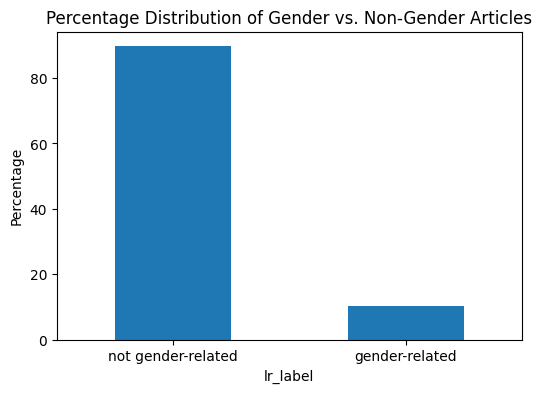

In [184]:
pct = df_100k_pred['lr_label'].value_counts(normalize=True) * 100
print(pct)

pct.plot(kind='bar', figsize=(6,4))
plt.ylabel("Percentage")
plt.title("Percentage Distribution of Gender vs. Non-Gender Articles")
plt.xticks(rotation=0)
plt.show()

The proportion is different than in the 2k sample. As our classifier is reliable in labeling gender-related articles, we accept this output as valid.

## 4.2. Gender related articles over time

### 4.2.1. Distribution of gender related articles over time

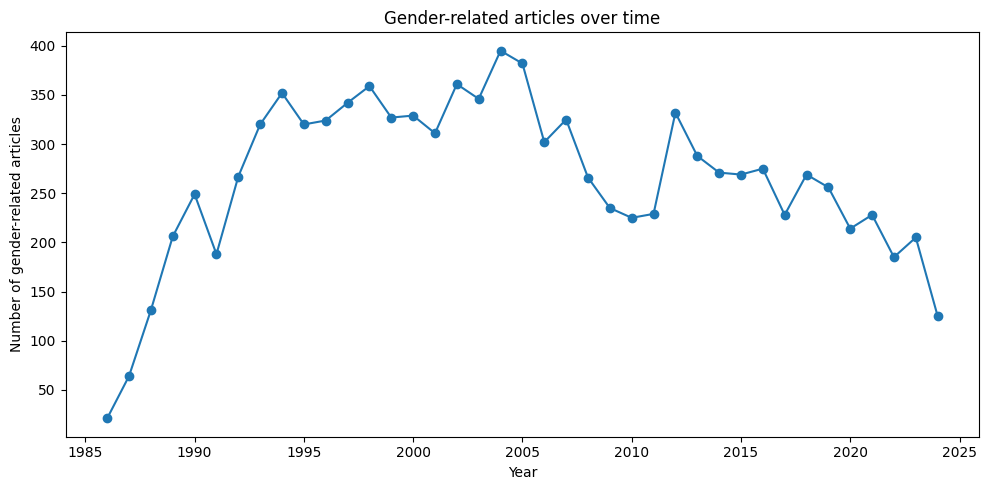

In [17]:
# --- map labels directly ---
# df_100k_pred = df_100k_pred.copy()
#df_100k_pred["lr_label"] = df_100k_pred["lr_label"].map({
    #"gender-related": 1,
    #"not gender-related": 0
#})

# drop rows where label mapping failed
#df_100k_pred = df_100k_pred.dropna(subset=["lr_label"])

# --- ensure year is integer ---
#df_100k_pred["year"] = pd.to_numeric(df_100k_pred["year"], errors="coerce")
#df_100k_pred = df_100k_pred.dropna(subset=["year"])
#df_100k_pred["year"] = df_100k_pred["year"].astype(int)
#df_100k_pred["lr_label"] = df_100k_pred["lr_label"].astype(int)

# --- aggregate ---
year_counts = (
    df_100k_pred.groupby("year")["lr_label"]
               .sum()
               .reset_index(name="count")
               .sort_values("year")
)

# --- plot ---
plt.figure(figsize=(10, 5))
plt.plot(year_counts["year"], year_counts["count"])
plt.scatter(year_counts["year"], year_counts["count"])
plt.xlabel("Year")
plt.ylabel("Number of gender-related articles")
plt.title("Gender-related articles over time")
plt.tight_layout()
plt.show()

Logically the distribution is equal to the total amounts of articles.

### 4.2.2. Proportion of gender related articles over time

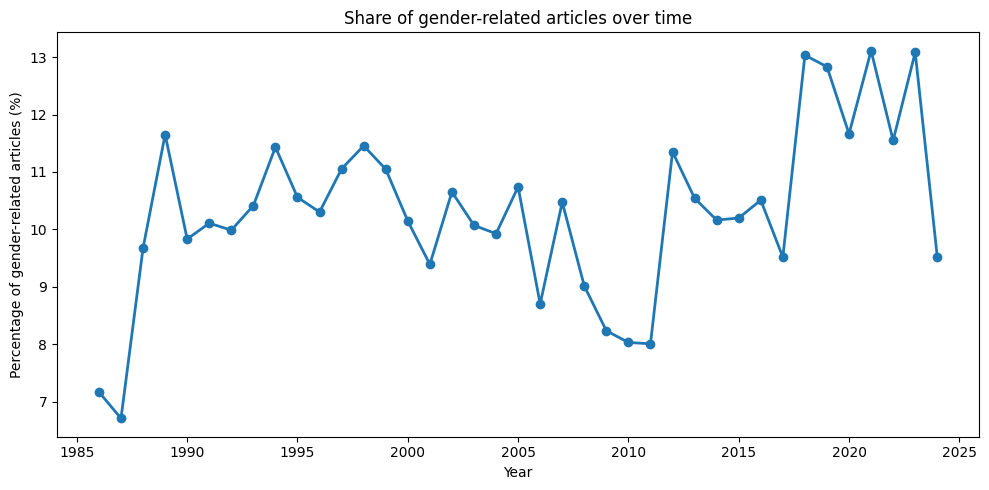

In [18]:
# ---- 1) Ensure year is numeric integer ----
df_100k_pred = df_100k_pred.copy()
df_100k_pred["year"] = pd.to_numeric(df_100k_pred["year"], errors="coerce")
df_100k_pred = df_100k_pred.dropna(subset=["year"]).copy()
df_100k_pred["year"] = df_100k_pred["year"].astype(int)

# ---- 2) Convert label → binary indicator (1 = gender related, 0 = not) ----
def label_to_binary(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()

    # common exact forms
    if s in {"gender-related", "gender related", "related", "1", "true", "yes"}:
        return 1
    if s in {"not gender-related", "not gender related", "not_related", "0", "false", "no"}:
        return 0

    # heuristic fallback
    contains_gender = "gender" in s
    negation = bool(re.search(r"\b(not|no|none|without|non)\b", s))

    if contains_gender and not negation:
        return 1
    if contains_gender and negation:
        return 0

    return None

df_100k_pred["is_gender_related"] = df_100k_pred["lr_label"].apply(label_to_binary)

# drop unmappable rows
df_100k_pred = df_100k_pred[df_100k_pred["is_gender_related"].notna()].copy()
df_100k_pred["is_gender_related"] = df_100k_pred["is_gender_related"].astype(int)

# ---- 3) Aggregate per year ----
agg = (
    df_100k_pred.groupby("year")
        .agg(
            total_articles=("is_gender_related", "size"),
            gender_related=("is_gender_related", "sum")
        )
        .reset_index()
        .sort_values("year")
)

# ---- 4) Compute percentage ----
agg["percent_gender_related"] = (
    agg["gender_related"] / agg["total_articles"] * 100
)

# ---- 5) Plot ----
plt.figure(figsize=(10, 5))
plt.plot(agg["year"], agg["percent_gender_related"], linewidth=2)
plt.scatter(agg["year"], agg["percent_gender_related"])
plt.xlabel("Year")
plt.ylabel("Percentage of gender-related articles (%)")
plt.title("Share of gender-related articles over time")
plt.tight_layout()
plt.show()

This is far more interesting and allows interpretation. Results and discussion can be found in the report.

In [19]:
table_gender_share = agg[[
    "year",
    "total_articles",
    "gender_related",
    "percent_gender_related"
]].copy()

table_gender_share["percent_gender_related"] = (
    table_gender_share["percent_gender_related"].round(2)
)

table_gender_share

,year,total_articles,gender_related,percent_gender_related
0,1986,293,21,7.17
1,1987,954,64,6.71
2,1988,1354,131,9.68
3,1989,1768,206,11.65
4,1990,2533,249,9.83
5,1991,1860,188,10.11
6,1992,2674,267,9.99
7,1993,3073,320,10.41
8,1994,3079,352,11.43
9,1995,3031,320,10.56


# Turn the dataframe into a parquet

In [188]:
df_100k_pred.to_parquet("df_100k_pred.parquet")